<a href="https://colab.research.google.com/github/sivavee/tsprediction/blob/dev/tsprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install fbprophet


In [17]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install -q pyarrow

In [15]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%load_ext google.colab.data_table

In [20]:
%%bigquery --project circular-matrix-300010 df_state
SELECT date as ds, country_code,subregion1_code, sum(new_confirmed) as y  FROM `bigquery-public-data.covid19_open_data.covid19_open_data` where country_code like 'IN' group by date, country_code,subregion1_code

In [25]:
%%bigquery --project circular-matrix-300010 df_country
SELECT date as ds, country_code, sum(new_confirmed) as y  FROM `bigquery-public-data.covid19_open_data.covid19_open_data` where country_code like 'IN' group by date, country_code

In [26]:
df_country.describe()

,y
count,363.000000
mean,73119.355372
std,73354.100220
min,-1355.000000
25%,605.000000
50%,52352.000000
75%,139959.000000
max,233913.000000


In [31]:
import pandas as pd
from fbprophet import Prophet

m = Prophet(daily_seasonality=False,weekly_seasonality=True,yearly_seasonality=True)
m.fit(df_country)

In [32]:
future_pd = m.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)
forecast_pd = m.predict(future_pd)
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
449,2021-03-25,32798.999485,20691.590262,45380.308211
450,2021-03-26,33289.853239,21614.603905,44624.023770
451,2021-03-27,31723.780090,19874.367662,43661.152300
452,2021-03-28,26927.589709,14849.728422,38385.266172
453,2021-03-29,23317.935051,11617.603826,36052.464876


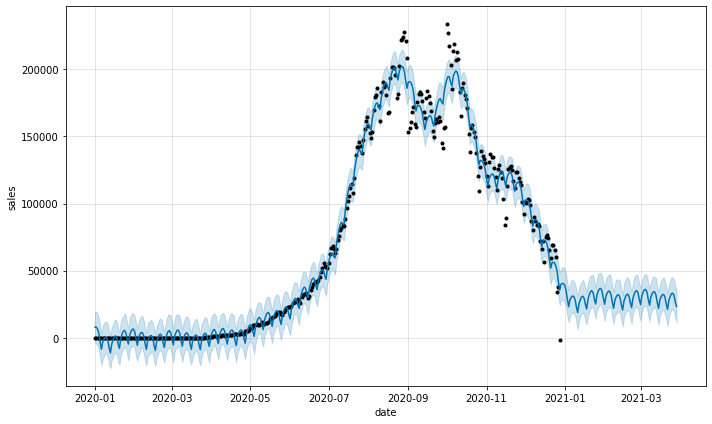

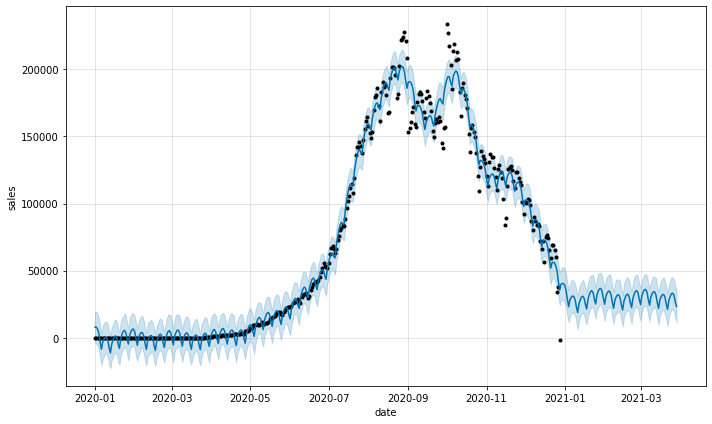

In [36]:
predict_fig = m.plot(forecast_pd, xlabel='date', ylabel='sales')
#display(predict_fig)

In [33]:


@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_store_item(history_pd):

    # instantiate the model, configure the parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    # fit the model
    model.fit(history_pd)

    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )

    # make predictions
    results_pd = model.predict(future_pd)

    # . . .

    # return predictions
    return results_pd

NameError: ignored